In [355]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

from PIL import Image
%matplotlib inline

In [2]:
dataset_path = r"..\dataset"

# Data Loading & Preprocessing

In [112]:
# Function Helper
# Data Loading Function (unpreprocessed)
def load_raw_data(dataset_path):
    data_dict = {}

    for label, folder_name in [(1, "CroppedPositiveDataAbove50Height"), (0, "CroppedNegativeData")]:
        folder_path = os.path.join(dataset_path, folder_name)
        
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)

            if img is not None:
                data_dict[filename] = (img, label)
            else:
                print(f"Error: Can't open image {filename}")

    return data_dict

# Data Loading Function with Label
def load_data(dataset_path, target_size=(128, 128)):
    images = []
    labels = []

    for label, folder_name in [(1, "CroppedPositiveDataAbove50Height"), (0, "CroppedNegativeData")]:
        folder_path = os.path.join(dataset_path, folder_name)
        
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            resized_image = cv2.resize(img, target_size)
            normalized_image = resized_image / 255
            flatten_image = normalized_image.flatten()

            if img is not None:
                images.append(flatten_image)
                labels.append(label)
            else:
                print(f"Error: Can't open image {filename}")

    return np.array(images), np.array(labels)

# Get average size/dim image
def get_average_image_size(images_dict):
    widths = []
    heights = []
    
    for filename, (image, label) in images_dict.items():
        if image is not None:
            h, w = image.shape[:2]
            widths.append(w)
            heights.append(h)
        else:
            print(f"Failed to read image: {filename}")
    
    if widths and heights:
        avg_width = int(np.mean(widths))
        avg_height = int(np.mean(heights))
    else:
        avg_width, avg_height = 0, 0
    
    return avg_width, avg_height

# Image Resize Function
def resize_images(images, size=(100, 100)):
    resized_images = {}
    for filename, (image, label) in images.items():  # Menyesuaikan akses tuple (image, label)
        resized_image = cv2.resize(image, size)
        resized_images[filename] = (resized_image, label)  # Simpan sebagai tuple dengan label
    return resized_images

# Image Visualization
def plot_image_grid(images, num_rows=10, num_cols=10, title="Image Grid", y_title=1, figsize=(12, 8), fontsize=50):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    for i, (filename, (image, label)) in enumerate(images.items()):  # Menyesuaikan akses tuple (image, label)
        if i < num_rows * num_cols:
            row_position = i // num_cols
            col_position = i % num_cols

            axes[row_position, col_position].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axes[row_position, col_position].axis('off')

    plt.suptitle(title, fontsize=fontsize, y=y_title)
    plt.tight_layout()
    plt.show()

In [113]:
images, labels = load_data(dataset_path, target_size=(128, 36))

In [39]:
images_dict = load_raw_data(dataset_path)

In [12]:
# Get the avg width & height
avg_width, avg_height = get_average_image_size(images_dict)
print(f'avg_width : {avg_width}')
print(f'avg_height : {avg_height}')

avg_width : 845
avg_height : 237


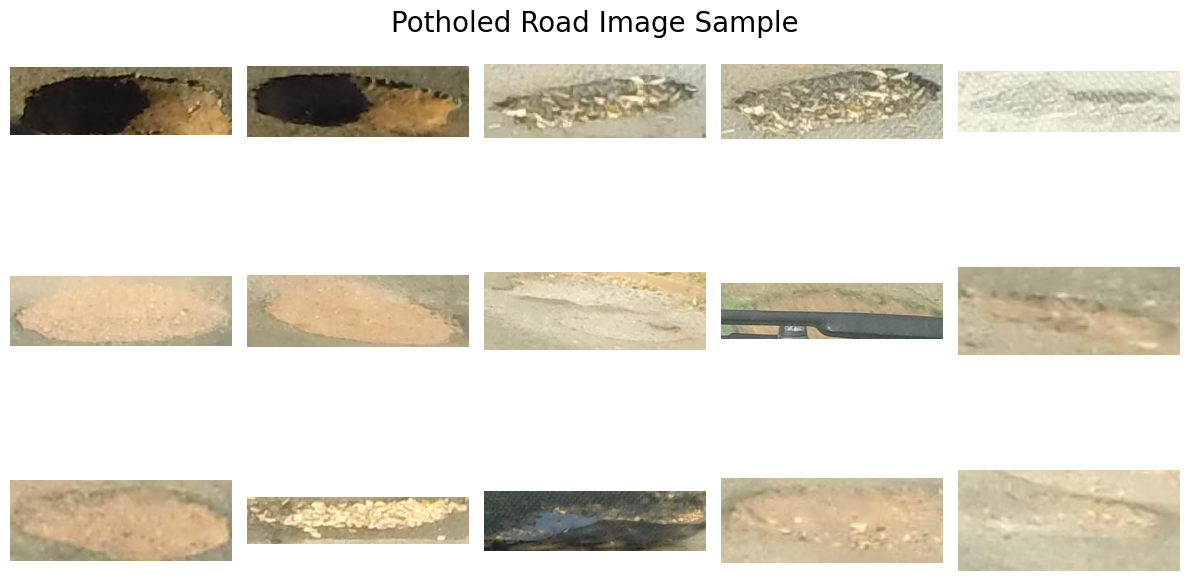

In [36]:
# Visualization for Positive or Pothole Image
positive_images = {filename: (image, label) for filename, (image, label) in images_dict.items() if label == 1}
plot_image_grid(positive_images, num_rows=3, num_cols=5, title='Potholed Road Image Sample', y_title=0.85, fontsize=20)

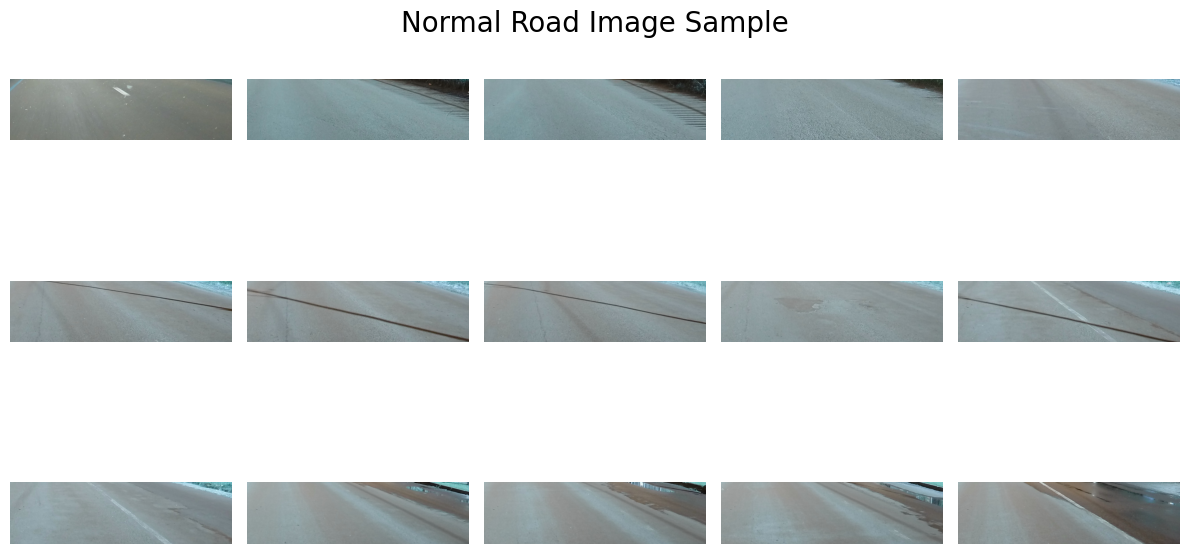

In [37]:
# Visualization for Negative or Normal Road Image
negative_images = {filename: (image, label) for filename, (image, label) in images_dict.items() if label == 0}
plot_image_grid(negative_images,num_rows=3, num_cols=5, title='Normal Road Image Sample', y_title=0.85, fontsize=20)

In [43]:
# Image Resizing
images_dict = resize_images(images_dict, size=(128, 36))

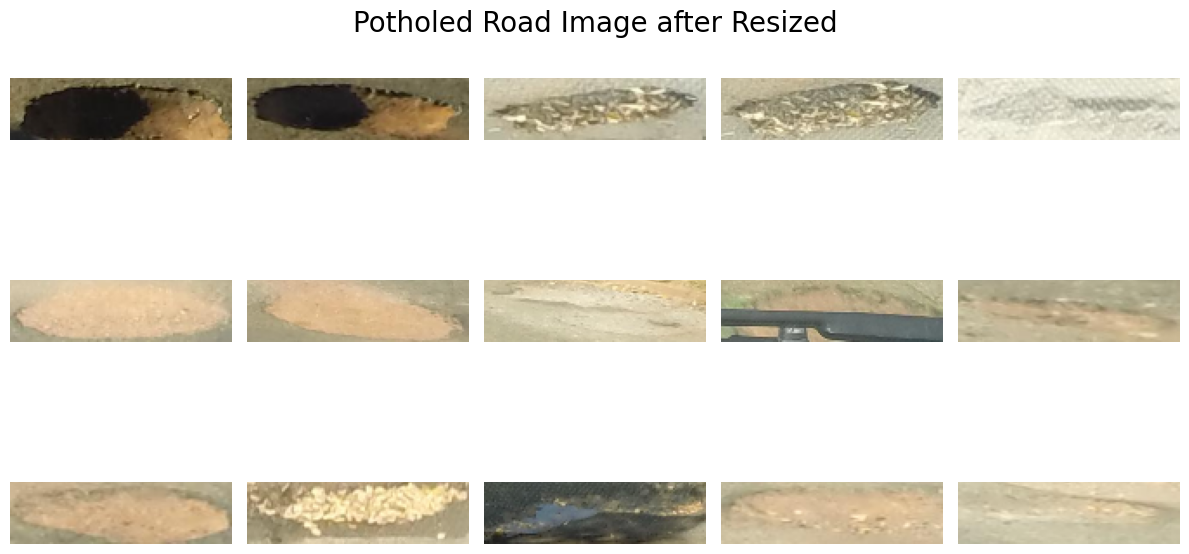

In [44]:
# Visualization for Positive or Pothole Image
positive_resized_images = {filename: (image, label) for filename, (image, label) in images_dict.items() if label == 1}
plot_image_grid(positive_resized_images,num_rows=3, num_cols=5, title='Potholed Road Image after Resized', y_title=0.85, fontsize=20)

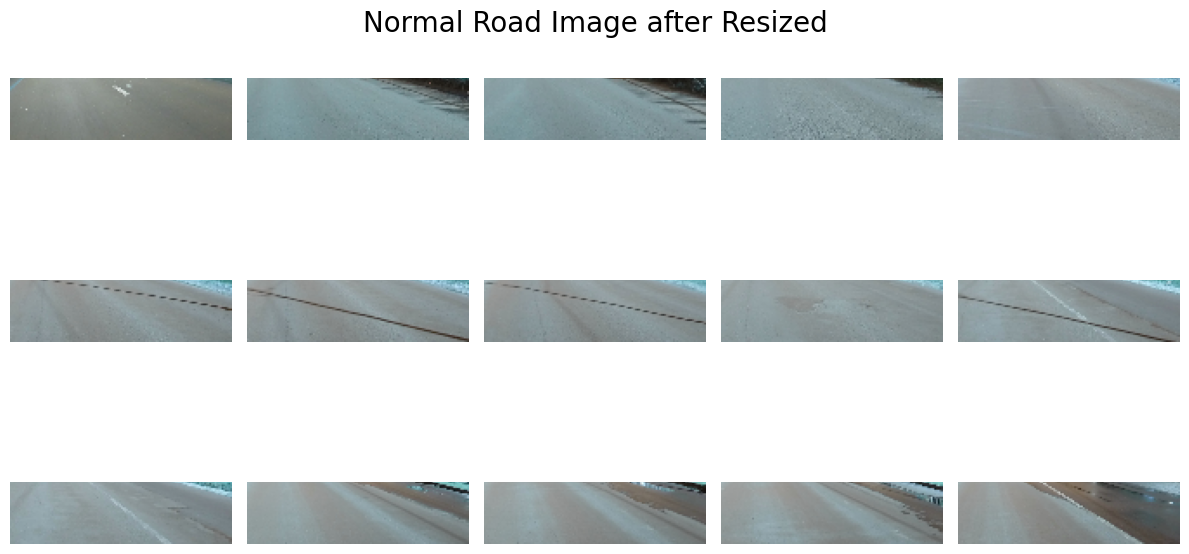

In [45]:
# Visualization for Negative or Normal Road Image
negative_resized_images = {filename: (image, label) for filename, (image, label) in images_dict.items() if label == 0}
plot_image_grid(negative_resized_images,num_rows=3, num_cols=5,title='Normal Road Image after Resized', y_title=0.85, fontsize=20)

# Modelling

In [173]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

In [ ]:
def sig(X):
  return 1 / (1 + np.exp(-X))

def sigd(X):
  sigmoid = sig(X)
  return sigmoid * (1 - sigmoid)

def softmax(X):
    exp_X = np.exp(X - np.max(X, axis=0, keepdims=True))
    return exp_X / np.sum(exp_X, axis=0, keepdims=True)

def relu(X):
   return np.maximum(0, X)

def relud(X):
   return (X > 0).astype(int)

def init_params(layers):
    params = {}
    for i in range(1, len(layers)):
        params[f'W{i}'] = np.random.rand(layers[i], layers[i-1]) - 0.5
        params[f'b{i}'] = np.random.rand(layers[i], 1) - 0.5
    return params

def feed_forward(X, params, layers):
    cache = {'A0': X}
    for i in range(1, len(layers)):
        Z = np.dot(params[f'W{i}'], cache[f'A{i-1}']) + params[f'b{i}']
        if i == len(layers) - 1:
            A = sig(Z)
        else:
            A = relu(Z)
        cache[f'Z{i}'] = Z
        cache[f'A{i}'] = A

    return cache

def back_prop(Y, cache, params, layers):
    grads = {}
    m = Y.size
    dZ = cache[f'A{len(layers) - 1}'] - Y

    for i in reversed(range(1, len(layers))):
        grads[f'dW{i}'] = 1 / m * dZ.dot(cache[f'A{i-1}'].T)
        grads[f'db{i}'] = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        if i > 1:
            dZ = params[f'W{i}'].T.dot(dZ) * relud(cache[f'Z{i-1}'])
    return grads

def update_params(params, grads, layers, alpha):
    for i in range(1, len(layers)):
        params[f'W{i}'] -= alpha * grads[f'dW{i}']
        params[f'b{i}'] -= alpha * grads[f'db{i}']
    return params

def get_predictions(X):
    return (X > 0.5).astype(int)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def binary_cross_entropy_loss(predictions, Y):
    epsilon = 1e-9  # untuk mencegah log(0)
    return -np.mean(Y * np.log(predictions + epsilon) + (1 - Y) * np.log(1 - predictions + epsilon))

def train(X, Y, layers, epochs, alpha):
    train_loss = []
    params = init_params(layers)
    for i in range(epochs):
        cache = feed_forward(X, params, layers)
        grads = back_prop(Y, cache, params, layers)
        params = update_params(params, grads, layers, alpha)
        if i % 10 == 0:
            predictions = get_predictions(cache[f'A{len(layers) - 1}'])
            loss = binary_cross_entropy_loss(predictions, Y)
            print(f"Epoch: {i}, Loss: {loss}")
            train_loss.append(loss)
    return params, train_loss

In [340]:
def predict(X_test, params, layers):
    cache = feed_forward(X_test, params, layers)
    predictions = get_predictions(cache[f'A{len(layers)-1}'])
    return predictions.flatten()

In [348]:
layers = (len(images[0]), 128, 128, 1)
params, loss = train(
    X = X_train.T,
    Y = y_train,
    layers = layers,
    epochs = 100,
    alpha=0.001
)

Epoch: 0, Loss: 16.701161170900708
Epoch: 10, Loss: 4.014248991869832
Epoch: 20, Loss: 4.006393318693962
Epoch: 30, Loss: 5.412558817174784
Epoch: 40, Loss: 1.1390726095012242
Epoch: 50, Loss: 0.9741034728079435
Epoch: 60, Loss: 0.9662477996320731
Epoch: 70, Loss: 0.8562683751698856
Epoch: 80, Loss: 0.7934229897629217
Epoch: 90, Loss: 0.7148662580042164


In [349]:
y_pred = predict(X_test.T, params, layers=layers)

# Evaluation

In [350]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score : ", accuracy)

Accuracy Score :  0.956060606060606


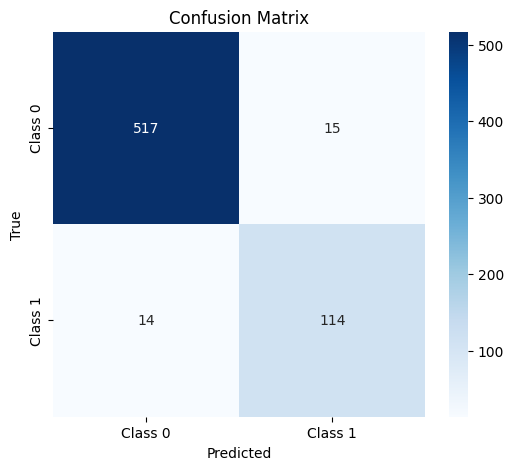

In [352]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [370]:
fig = px.line(loss)
fig.update_layout(
    title_text = 'Cross Entropy Loss / 10 Epoch',
    width = 1000,
    height = 400,
    showlegend = False
)
fig.update_xaxes(title_text = 'Epoch')
fig.update_yaxes(title_text = 'Loss')
fig.show()

In [377]:
# Import parameter model untuk pengujian di streamlit
import json

params_serializable = {key: value.tolist() if isinstance(value, np.ndarray) else value for key, value in params.items()}
with open('params.json', 'w') as json_file:
    json.dump(params_serializable, json_file)